In [1]:
from IPython.display import Image

### 4.1.1 테이블 형태 데이터에서 누락된 값 식별

In [2]:
import pandas as pd
from io import StringIO
import sys

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [3]:
df.isnull().sum()
# df.isnull().sum().sum() 하면 null 값 총합이 나옴

A    0
B    0
C    1
D    1
dtype: int64

In [4]:
df.values # .values returns ndarray

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

### 4.1.2 누락된 값이 있는 훈련 샘플이나 특성 제외

In [5]:
# 누락된 값이 있는 행을 삭제한다.
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [6]:
# 누락된 값이 있는 열을 삭제한다.
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [7]:
# 모든 열이 NaN인 행을 삭제한다.
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [8]:
# NaN 아닌 값이 네 개보다 작은 행을 삭제한다.
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [9]:
# 특정 열에 NaN이 있는 행만 삭제한다 (여기서는 'C'열)
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


### 4.1.3 누락된 값 대체

In [10]:
# 원래 배열
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

In [11]:
# 행의 평균으로 누락된 값 대체하기
from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

# strategy = mean, median, most_frequent, constant 중 지정 가능
# axis 변수 설정 못함! axis=0 이 기본 세팅 => 행 방향(아래로 내려오는 방향)으로 계산

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [12]:
# axis=1 방향으로 대체하려면 FunctionTransformer 사용해야됌
from sklearn.preprocessing import FunctionTransformer

ftr_imr = FunctionTransformer(lambda X: imr.fit_transform(X.T).T)
imputed_data = ftr_imr.fit_transform(df.values)
imputed_data

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  6.33333333,  8.        ],
       [10.        , 11.        , 12.        , 11.        ]])

`SimpleImputer` 클래스의 `add_indicator` 매개변수를 `True`로 지정하면 `indicator_` 속성이 추가되고 `transform()` 메서드가 누락된 값의 위치를 포함된 배열을 반환합니다.

In [13]:
imr = SimpleImputer(add_indicator=True)
imputed_data = imr.fit_transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ,  0. ,  0. ],
       [ 5. ,  6. ,  7.5,  8. ,  1. ,  0. ],
       [10. , 11. , 12. ,  6. ,  0. ,  1. ]])

추가된 `indicator_` 속성은 `MissingIndicator` 클래스의 객체입니다.

In [14]:
imr.indicator_

MissingIndicator(error_on_new=False)

`MissingIndicator` 객체의 `features_` 속성은 누락된 값이 있는 특성의 인덱스를 담고 있습니다.

In [15]:
imr.indicator_.features_

array([2, 3])

`MissingIndicator` 객체의 `fit_transform()` 메서드를 호출하면 `features_` 속성에 담긴 특성에서 누락된 값의 위치를 나타내는 배열을 반환합니다. 여기에서는 세 번째, 네 번째 특성의 누락된 값의 위치입니다. 이 배열의 값이 `SimpleImputer` 객체의 `transfrom()` 메서드가 반환한 배열의 마지막 두 열에 해당합니다.

In [16]:
imr.indicator_.fit_transform(df.values)

array([[False, False],
       [ True, False],
       [False,  True]])

In [17]:
# 사이킷런 0.24 버전에서 추가되었습니다.
imr.inverse_transform(imputed_data)

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

`SimpleImputer`는 한 특성의 통곗값을 사용하여 누락된 값을 채웁니다. 이와 달리 `IterativeImputer` 클래스는 다른 특성을 사용하여 누락된 값을 예측합니다. 먼저 `initial_strategy` 매개변수에 지정된 방식으로 누락된 값을 초기화합니다. 그다음 누락된 값이 있는 한 특성을 타깃으로 삼고 다른 특성을 사용해 모델을 훈련하여 예측합니다. 이런 식으로 누락된 값이 있는 모든 특성을 순회합니다.

`initial_strategy` 매개변수에 지정할 수 있는 값은 `SimpleImputer`와 동일하게 `'mean'`, `'median'`, `'most_frequent'`, `'constant'`가 가능합니다.

예측할 특성을 선택하는 순서는 누락된 값이 가장 적은 특성부터 선택하는 `'ascending'`, 누락된 값이 가장 큰 특성부터 선택하는 `'descending'`, 왼쪽에서 오른쪽으로 선택하는 `'roman'`, 오른쪽에서 왼쪽으로 선택하는 `'arabic'`, 랜덤하게 고르는 `'random'`이 있습니다. 기본값은 `'ascending'`입니다.

특성 예측은 종료 조건을 만족할 때까지 반복합니다. 각 반복 단계에서 이전 단계와 절댓값 차이 중 가장 큰 값이 누락된 값을 제외하고 가장 큰 절댓값에 `tol` 매개변수를 곱한 것보다 작을 경우 종료합니다. `tol` 매개변수 기본값은 1e-3입니다. 또는 `max_iter` 매개변수에서 지정한 횟수에 도달할 때 종료합니다. `max_iter`의 기본값은 10입니다.

예측에 사용하는 모델은 `estimator` 매개변수에서 지정할 수 있으며 기본적으로 `BayesianRidge` 클래스를 사용합니다. 예측에 사용할 특성 개수는 `n_nearest_features`에서 지정할 수 있으며 상관 계수가 높은 특성을 우선하여 랜덤하게 선택합니다. 기본값은 `None`으로 모든 특성을 사용합니다.

In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iimr = IterativeImputer()
iimr.fit_transform(df.values)

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  7.00047063,  8.        ],
       [10.        , 11.        , 12.        , 12.99964527]])

`KNNImputer` 클래스는 K-최근접 이웃 방법을 사용해 누락된 값을 채웁니다. 최근접 이웃의 개수는 `n_neighbors` 매개변수로 지정하며 기본값은 5입니다. 샘플 개수가 `n_neighbors` 보다 작으면 `SimpleImputer(strategy='mean')`과 결과가 같습니다.

In [19]:
from sklearn.impute import KNNImputer

kimr = KNNImputer()
kimr.fit_transform(df.values)

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [20]:
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


`fillna()` 메서드의 `method` 매개변수를 사용하여 누락된 값을 채울 수도 있습니다. `bfill` 또는 `backfill`은 누락된 값을 다음 행의 값으로 채웁니다. `ffill` 또는 `pad`는 누락된 값을 이전 행의 값으로 채웁니다.

In [21]:
df.fillna(method='bfill') # method='backfill'와 같습니다

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,12.0,8.0
2,10.0,11.0,12.0,NaN


In [22]:
df.fillna(method='ffill') # method='pad'와 같습니다

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,3.0,8.0
2,10.0,11.0,12.0,8.0


`axis=1`로 지정하면 행이 아니라 열을 사용합니다. 예를 들어 다음처럼 지정하면 이전 열의 값으로 누락된 값을 채웁니다.

In [23]:
df.fillna(method='ffill', axis=1)

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,6.0,8.0
2,10.0,11.0,12.0,12.0


### 4.1.4 사이킷런 추정기 API 익히기

- SimpleImputer의 클래스는 'transformer'다.
    - 이 클래스의 주요 메서드 두 개는 fit과 transform.
    - fit을 사용하여 훈련 데이터에서 모델 파라미터를 학습하고,
    - transform을 사용하여 학습한 파라미터로 데이터를 변환한다.

## 4.2 범주형 데이터 다루기

In [24]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])
df.columns = ['color', 'size', 'price','classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


### 4.2.1 순서가 있는 특성 매핑
- 순서 특성을 올바르게 인식하려면 범주형의 문자열을 정수로 바꿔야 한다. => 매핑 함수를 직접 만들어야 한다.

In [25]:
size_mapping = {'XL': 3,
               'L': 2,
               'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [26]:
# 아래는 inverse_mapping, 즉 원래대로 돌려놓는 매핑이다.
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

### 4.2.2 클래스 레이블 인코딩

In [27]:
import numpy as np

# 클래스 레이블을 정수로 바꾸기 위해 매핑 딕셔너리 만들기
class_mapping = {label: idx for idx, label in\
                enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [28]:
# 클래스 레이블을 문자열에서 정수로 바꾸기
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [29]:
# 클래스 레이블 거꾸로 매핑하기
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [30]:
from sklearn.preprocessing import LabelEncoder

# 사이킷런의 LabelEncoder를 사용한 레이블 인코딩
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

In [31]:
# 거꾸로 매핑
class_le.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)

In [32]:
class_le.classes_

array(['class1', 'class2'], dtype=object)

### 4.2.3 순서가 없는 특성에 원-핫 인코딩 적용

> 앞에서 한 거 요약
> - 순서가 있는 특성 매핑하기 위해 dictionary mapping 활용
> - 순서가 없는 클래스 레이블을 정수로 바꾸기 위해 sklearn의 LabelEncoder 활용
> - **순서가 없는 특성**을 매핑하기 위해 One-Hot Encoding이라는 기법도 있음!

In [33]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

# .values를 한 이유는 LabelEncoder가 입력 값으로 클래스 레이블을 기대하기 때문에 ndarray로 줘야 한다.

# 근데..!!!!
    # 이렇게 하고 분류기에 넣으면, 분류기는 color 특성에 '순서가 있다고 판단'하게 된다.

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [34]:
# "순서가 없는 특성"을 매핑하기 위한 일반적인 방법이 One-Hot Encoding이다.
from sklearn.preprocessing import OneHotEncoder

X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()
    # 배열의 다른 두 열을 수정하지 않기 위해 하나의 열(X[:, 0].reshape(-1, 1))에만 적용했다.

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [35]:
# 여러 개의 특성이 있는 배열에서 특정 열만 변환하려면 ColumnTransformer를 사용한다.
from sklearn.compose import ColumnTransformer

X = df[['color', 'size', 'price']].values
c_transf = ColumnTransformer([ ( 'onehot', OneHotEncoder(), [0]),
                               ( 'nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X)

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

In [36]:
# one-hot encoding via pandas
pd.get_dummies(df[['price', 'color', 'size']], columns=['size'], drop_first=True)

,price,color,size_2,size_3
0,10.1,green,0,0
1,13.5,red,1,0
2,15.3,blue,0,1


## 4.3 데이터셋을 훈련 데이터셋과 테스트 데이터셋으로 나누기

In [37]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols',
                   'Proanthocyanins', 'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [38]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.3,
                                                   random_state=0,
                                                   stratify=y)

## 4.4 특성 스케일 맞추기
- Decision Tree와 Random Forest는 특성 스케일 조정을 걱정할 필요 없는 몇 안되는 알고리즘 중 하나다.
- 대부분의 머신 러닝과 최적화 알고리즘은 특성 스케일이 같을 때 훨씬 성능이 좋다.

**용어가 뒤바뀌어 사용될 때가 있지만 일반적인 경우에..**<br>
- 정규화(normalization)
    - 특성 스케일을 [0, 1]의 범위로 맞추는 것
    - 정해진 범위의 값이 필요할 때 유용하게 사용된다.
    - 최소-최대 스케일 변환(min-max scaling)
    - $x^{(i)}_{norm} = \dfrac{x^{(i)} - x_{min}}{x_{max} - x_{min}}$
        - $x^{(i)}$는 특정 샘플, $x_{min}$은 특성 중 가장 작은 값, $x_{max}$는 특성 중 가장 큰 값 <br><br>
        
- 표준화(standardization)
    - 특성을 평균 0, 표준 편차 1인 표준정규분포의 형태로 만드는 기법
    - 경사 하강법 같은 최적화 알고리즘에 많이 사용된다. 표준정규분포 형태는 '가중치를 더 쉽게 학습할 수 있도록 만든다.'
    - $x^{(i)}_{std} = \dfrac{x^{(i)} - \mu_x}{\sigma_x}$

In [39]:
# min-max scaling
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [40]:
# standardization
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

`RobustScaler`는 중간값(q2) 값을 빼고 1사분위(q1)와 3사분위(q3)의 차이로 나누어 데이터의 스케일을 조정합니다.

$ x_{robust}^{(i)} = \dfrac{x^{(i)} - q_2}{q_3 - q_1}$

In [41]:
from sklearn.preprocessing import RobustScaler
rbs = RobustScaler()
X_train_robust = rbs.fit_transform(X_train)
X_test_robust = rbs.fit(X_test)

`MaxAbsScaler`는 각 특성별로 데이터를 최대 절댓값으로 나눕니다. 따라서 각 특성의 최댓값은 1이 됩니다. 전체 특성은 [-1, 1] 범위로 변경됩니다.

In [42]:
from sklearn.preprocessing import MaxAbsScaler
mas = MaxAbsScaler()
X_train_maxabs = mas.fit_transform(X_train)
X_test_maxabs = mas.transform(X_test)

마지막으로 `Normalizer` 클래스와 `normalize()` 함수는 특성이 아니라 샘플별로 정규화를 수행합니다. 또한 희소 행렬도 처리할 수 있습니다. 기본적으로 샘플의 L2 노름이 1이 되도록 정규화합니다.

In [43]:
from sklearn.preprocessing import Normalizer

nrm = Normalizer()
X_train_l2 = nrm.fit_transform(X_train)

**L2 Norm**<br>
$ \lVert \boldsymbol{x} \rVert_2 = \sqrt{x_1^2 + x_2^2 + \cdots + x_n^2} $<br><br>

**L1 Norm**<br>
$ \lVert \boldsymbol{x} \rVert_1 = \lvert x_1 \rvert + \lvert x_2 \rvert + \cdots + \lvert x_n \rvert $

## 4.5 유용한 특성 선택

- train set에 대한 overfitting을 방지하기 위한 방법은 여러 가지가 있다. (일반화 오차를 감소하기 위한 기법)
    - 더 많은 훈련 데이터를 모은다
    - 규제를 통해 복잡도를 제한한다
    - 파라미터 개수가 적은 간단한 모델을 선택한다
    - 데이터 차원을 줄인다

### 4.5.1 모델 복잡도 제한을 위한 L1 규제와 L2 규제

$L2: \lVert \boldsymbol w \rVert_2^2 = \sum_{j=1}^m w_j^2$

$L1: \lVert \boldsymbol w \rVert_1 = \sum_{j=1}^m \lvert w_j \rvert$

In [44]:
Image(url='https://git.io/JtY8I', width=350) 

In [45]:
Image(url='https://git.io/JtY8L', width=350) 

### 4.5.3 L1 규제를 사용한 희소성

In [46]:
Image(url='https://git.io/JtY8t', width=400) 

- L1 규제의 특징은..
    - 비용 함수의 포물선과 L1 다이아몬드의 경계가 만나는 최적점이 "축에 가깝게 위치할 가능성이 높다는 것"
    - 그래서 L1 규제는 보통 희소한 특성 벡터를 만든다. (대부분의 특성 가중치가 0이 된다)
    - 관련 없는 특성이 많은 고차원 데이터셋일 경우 이런 희소성이 도움이 될 수 있다.

In [47]:
# L1 규제 사용 예시
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1', solver='liblinear')

LogisticRegression(penalty='l1', solver='liblinear')

In [48]:
# 표준화 전처리된 wine 데이터에 적용해보기
lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', random_state=1)
    # 규제 효과를 높이거나 낮추려면 C값을 증가시키거나 감소시키면 됌! (C=1.0이 기본값)
lr.fit(X_train_std, y_train)
print('훈련 정확도:', lr.score(X_train_std, y_train))
print('테스트 정확도:', lr.score(X_test_std, y_test))

훈련 정확도: 1.0
테스트 정확도: 1.0


In [49]:
lr.intercept_
    # OvR 방식을 사용하기 때문에 절편이 3개다.
    # wine 데이터셋의 y 레이블이 3가지 종류다.

array([-1.26392152, -1.21596534, -2.37040177])

In [50]:
lr.coef_[lr.coef_!=0].shape

(23,)

In [51]:
lr.coef_
    # 꽤 많은 특성이 0으로 처리됐다.

array([[ 1.24567209,  0.18072301,  0.74682115, -1.16438451,  0.        ,
         0.        ,  1.1595535 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55864751,  2.50891241],
       [-1.53644846, -0.38769843, -0.99485417,  0.36489012, -0.05989298,
         0.        ,  0.66853184,  0.        ,  0.        , -1.93460212,
         1.23246414,  0.        , -2.23212696],
       [ 0.1355558 ,  0.16880291,  0.35718019,  0.        ,  0.        ,
         0.        , -2.43768478,  0.        ,  0.        ,  1.5635432 ,
        -0.81834553, -0.4930494 ,  0.        ]])

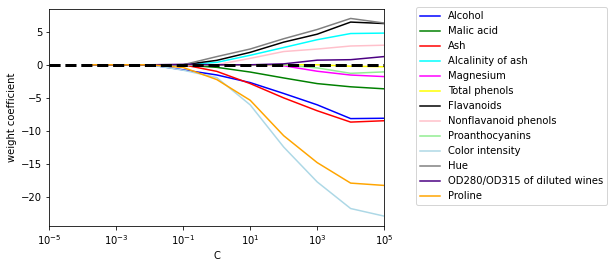

In [52]:
# 규제 강도에 따른 특성의 가중치 변화를 그래프로 나타내기
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear', 
                            multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
# plt.savefig('images/04_07.png', dpi=300, 
#             bbox_inches='tight', pad_inches=0.2)
plt.show()

- 위에서 볼 수 있듯이 L1규제는 C가 낮아질수록(규제가 강해질수록) 모든 가중치가 0에 수렴한다.

### 4.5.4 순차 특성 선택 알고리즘
- 특성 선택을 통한 차원축소도 모델 복잡도를 낮추고 과대적합을 피하는 방법 중 하나다.
    - 특히.. 규제를 쓸 수 없는 모델에서 유용하다.
- 차원 축소 기법에는 두 개의 주요 카테고리가 있다.
    - 특성 선택(feature selection): 원본 특성에서 일부를 선택하는 것
    - 특성 추출(feature extraction): 일련의 특성에서 얻은 정보로 새로운 특성을 만드는 것

> - 순차 특성 선택(sequential feature selection)은 '탐욕적 탐색 알고리즘(greedy search algorithm)'으로 초기 $d$차원의 특성 공간을 $k < d$인 $k$차원의 특성 부분 공간으로 축소한다.<br>
> - 전통적 순차특성선택 알고리즘으로 순차 후진 선택(Sequential Backward Selection, SBS)가 있다.

- SBS는 새로운 특성의 부분 공간이 목표하는 특성 개수가 될 때까지 전체 특성에서 순차적으로 특성을 제거한다.
    - 각 단계에서 어떤 특성을 제거할지 판단하기 위해 최대화할 기준 함수를 정의한다.<br>
    
1. 알고리즘을 $k=d$로 초기화한다. $d$는 전체 특성 공간 $\boldsymbol X_d$의 차원이다.
2. 조건 $\boldsymbol x^- = argmax\;J(\boldsymbol X_k - \boldsymbol x)$를 최대화하는 특성 $\boldsymbol x^-$를 결정한다.
3. 특성 집합에서 특성 $\boldsymbol x^-$를 제거한다.
4. $k$가 목표하는 특성 개수가 되면 종료한다. 아니면 단계2로 돌아간다.

In [53]:
# SBS 구현하기
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                            random_state=self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
            # self.indicies_ = (0, 1, 2, ..., 11, 12) *feature개수 13개
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,
                                        X_test, y_test, p)
                scores.append(score) # 각 feature 조합의 score
                subsets.append(p)  # feature의 조합
            
            best = np.argmax(scores)  # score리스트에서 score가 가장 높은 행의 index 반환
            self.indices_ = subsets[best]  # subsets[best] = 가장 점수가 높은 feature 조합. => self.indices_가 된다. => 이 self.indices_는 dim - 1개의 feature 조합이고, 이게 다시 for문 위로 올라간다.
            self.subsets_.append(self.indices_) #이 feature 조합을 self.subsets_에 저장한다.
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]  # k개의 feature가 남았을 때의 score는 scores_ 리스트에 마지막으로 입력된 score다.
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

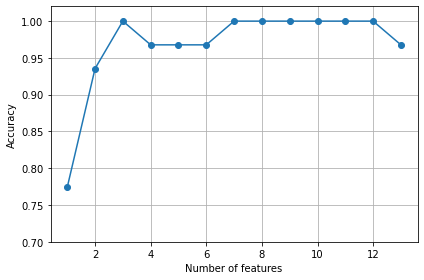

In [54]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# 특성을 선택한다
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# 선택한 특성의 성능을 출력한다
k_feat = [len(k) for k in sbs.subsets_]  # subsets_ 리스트에 담긴 원소들은 feature 조합의 원소 갯수다. => 이게 그래프의 x축이 된다.

plt.plot(k_feat, sbs.scores_, marker='o')  # feature 조합 원소 갯수에 따라서 scores_ 가 어떻게 바뀌는지 보여준다
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()

plt.show()

In [55]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])
    # columns[1:]한 이유는 1번 칼럼이 class label이기 때문!

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [56]:
knn.fit(X_train_std, y_train)
print('훈련 정확도:', knn.score(X_train_std, y_train))
print('테스트 정확도:', knn.score(X_test_std, y_test))

훈련 정확도: 0.967741935483871
테스트 정확도: 0.9629629629629629


In [57]:
knn.fit(X_train_std[:, k3], y_train)
print('훈련 정확도:', knn.score(X_train_std[:, k3], y_train))
print('테스트 정확도:', knn.score(X_test_std[:, k3], y_test))

훈련 정확도: 0.9516129032258065
테스트 정확도: 0.9259259259259259


## 4.6 랜덤 포레스트의 특성 중요도 사용

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


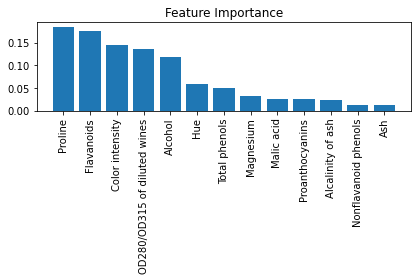

In [58]:
# wine 데이터셋에서 500개의 트리를 가진 랜덤 포레스트를 훈련하고 각각의 중요도에 따라 13개의 특성에 순위를 매겨보자
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500, random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]  # [::-1]은 ascending=False

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                           feat_labels[indices[f]],
                           importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),
       importances[indices],
       align='center')

plt.xticks(range(X_train.shape[1]),
          feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()

plt.show()

> **"랜덤 포레스트에서 두 개 이상의 특성이 매우 상관관계가 높다면 하나의 특성은 매우 높은 순위를 갖지만 다른 특성 정보는 완전히 무시될 수도 있다."**

In [59]:
# SelectFromModel은 특성중요도가 threshold(0.1) 이상인 특성들을 선택해주는 클래스다.
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('이 임계 조건을 만족하는 샘플의 수:',
     X_selected.shape[1])

이 임계 조건을 만족하는 샘플의 수: 5


In [60]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529


- RFE 라는 클래스도 있다. 이건 처음에 모든 특성을 사용하여 모델을 만들고, 특성 중요도가 가장 낮은 특성을 제거해서 나머지 특성으로 새로운 모델을 만들고, 이걸 미리 정의한 특성 개수가 남을 때까지 계속 하는 기법이다.

In [61]:
from sklearn.feature_selection import RFE

rfe = RFE(forest, n_features_to_select=5)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(n_estimators=500, random_state=1),
    n_features_to_select=5)

In [62]:
# 1은 모델이 최종적으로 선택한 5가지 특성이다. 2는 마지막에 짤린 특성.
rfe.ranking_

array([1, 5, 9, 6, 4, 3, 1, 8, 7, 1, 2, 1, 1])

In [63]:
# support_는 최종 선택된 특성을 boolean으로 반환한다.
f_mask = rfe.support_

In [64]:
# 훈련된 기반 모델(random forest)는 estimator_ 속성에 저장되어 있다.
    # 이 모델의 특성 중요도를 추출해보자
importances = rfe.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

for i in indices:
    print("%2d) %-*s %f" % (f + 1, 30,
                           feat_labels[f_mask][i],
                           importances[i]))

 5) Proline                        0.261512
 5) Color intensity                0.216477
 5) Flavanoids                     0.212259
 5) OD280/OD315 of diluted wines   0.188924
 5) Alcohol                        0.120828


## 5.1 주성분 분석을 통한 비지도 차원 축소

**SBS 같은 특성 선택 알고리즘은 "원본 특성을 유지"하지만, 특성 추출은 새로운 특성 공간으로 데이터를 변환하거나 투영한다.**<br>
> - PCA: 비지도 차원 축소<br>
> - LDA: 지도 차원 축소<br>
> - 커널 PCA: 비선형 차원 축소

### 5.1.1 주성분 분석의 주요 단계

In [65]:
Image(url='https://git.io/JtsvW', width=400) 

- 훈련 샘플의 특성 벡터 $\boldsymbol x = [x_1, x_2, ..., x_d]$가 있을 때,
    - 이 특성 벡터의 차원을 축소하기 위해 $d \times k$ 차원의 변환 행렬 $\boldsymbol W$를 만든다.
    - 이 변환행렬과 특성 벡터 $\boldsymbol x$를 새로운 $k$ 차원의 특성 부분 공간으로 매핑한다.<br><br>

$$ \boldsymbol x \boldsymbol W = \boldsymbol z$$

- PCA 방향은 데이터 스케일에 매우 민감하다.
    - 특성의 스케일이 다르고 모든 특성의 중요도를 동일하게 취급하려면 PCA를 적용하기 전에 특성을 표준화 전처리해야 한다.<br>
    
1. $d$ 차원 데이터셋을 표준화 전처리한다.
2. 공분산 행렬(covariance matrix)을 만든다.
3. 공분산 행렬을 고유 벡터(eigenvector)와 고윳값(eigenvalue)으로 분해한다.
4. 고윳값을 내림차순으로 정렬하고 그에 해당하는 고유 벡터의 순위를 매긴다.
5. 고윳값이 가장 큰 $k$개의 고유 벡터를 선택한다. 여기서 $k$는 새로운 특성 부분 공간의 차원이다. ($k\leq d$)
6. 최상위 $k$개의 고유 벡터로 투영 행렬(projection matrix) $\boldsymbol W$를 만든다.
7. 투영 행렬 $\boldsymbol W$를 사용해서 $d$차원 입력 데이터셋 $\boldsymbol X$를 새로운 $k$ 차원의 특성 부분 공간으로 변환한다.

### 5.1.2 주성분 추출 단계

#### 1~4단계를 파이썬으로 직접 구현해보자

In [66]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols',
                   'Proanthocyanins', 'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [67]:
# train test split
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3,
                    stratify=y, random_state=0)

In [68]:
# standardization
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [69]:
# 공분산 행렬의 고윳값 분해
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\n고윳값 \n%s' % eigen_vals)

    # 사이킷런의 PCA 클래스는 직접 고윳값과 고유 벡터를 계산하는 대신 특이값분해(singular value decomposition) 방식을 사용하여 주성분을 구한다.


고윳값 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


- 고윳값을 크기에 따라 내림차순으로 정렬하기 이전에,
    - 고윳값의 '설명된 분산 비율(explained variance ratio)'를 시각화해보자
    - 고윳값 $\lambda_j$의 설명된 분산 비율은 전체 고윳값의 합에서 고윳값 $\lambda_j$의 비율이다.<br><br>
    
$$ Explained\;Variance\;Ratio\;=\; \dfrac {\lambda_j}{\sum^d_{j=1}\lambda_j}$$

In [70]:
# cumsum으로 explained variance ratio 계산하고, step 함수로 시각화한다
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

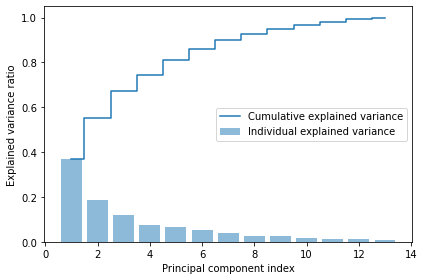

In [71]:
import matplotlib.pyplot as plt

plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
       label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
        label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

> - 기억할 것!<br>
> - PCA는 비지도 학습이다. 레이블 데이터는 사용하지 않았다. 위 그래프는 "어떤 주성분이 특성 간의 공분산 관계를 가장 잘 설명하는지"를 나타낸다.

In [72]:
# (고윳값, 고유벡터) 튜플의 리스트를 만든다
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
              for i in range(len(eigen_vals))]

# 높은 값에서 낮은 값으로 (고윳값, 고유벡터) 튜플을 정렬한다
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [73]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
              eigen_pairs[1][1][:, np.newaxis]))
print('투영 행렬 W:\n', w)

# eigen_pairs는 (eigen_val, eigen_vec(13차원)) 튜플의 리스트다.
    # eigen_pairs[0] 하면 첫 번째 튜플이 선택되고,
    # eigen_pairs[0][1] 하면 첫 번째 튜플의 eigen vec이 선택된다.
    # eigen_pairs[0][1]은 shape이 (13,)의 1차원 배열인데, 여기다가 [:, np.newaxis]를 해주면 (13,1)의 13차원 열벡터가 된다.

투영 행렬 W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


- 위의 투영행렬 $\boldsymbol W$은 가장 고윳값이 높은 고유벡터 2개를 이어 붙인 $13 \times 2$차원의 행렬이다.
    - 기존 특성벡터 $\boldsymbol x$는 13차원인데, 이걸 2차원으로 줄이는 것이다.

In [74]:
X_train_std[0].dot(w)

# 이게 무슨 뜻이냐면
    # 특성 13개를 갖고 있던 X의 샘플 데이터 하나를 투영행렬과 내적하여
    # 기존 샘플데이터를 2개 차원의 특성을 지닌 샘플데이터로 축소시킨 것이다.

array([2.38299011, 0.45458499])

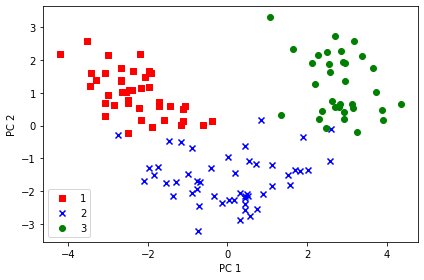

In [75]:
# 전체 X 훈련 데이터셋을 주성분에 투영한다
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],
               X_train_pca[y_train == l, 1],
               c=c, label=l, marker=m)    
            # 각각의 레이블 데이터마다 (주성분1, 주성분2)의 좌표를 반환

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()

plt.show()

- 위 그래프는 기존 124x13 차원의 데이터를 124x2 차원의 데이터로 변환한 후, 2차원 산점도로 시각화한 것이다.
- 데이터가 y축(두 번째 주성분)보다 x축(첫 번째 주성분)을 따라 더 넓게 퍼져있다.
    - 전에 설명된 분산 그래프에서 1번째와 2번째 주성분의 explained variance 차이가 꽤 컸는데, 그게 똑같이 반영된 거다.
- 딱봐도 이 데이터에 선형분류기를 쓰면 클래스들을 잘 분리할 수 있을 거 같다 => 다시 말해, 2차원으로 차원 축소가 꽤 성공적으로 이뤄졌다.

### 5.1.5 사이킷런의 주성분 분석

#### 앞의 내용을 사이킷런에서 똑같이 구현해보자

In [76]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

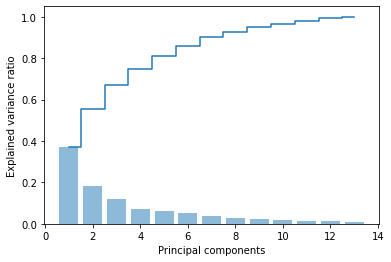

In [77]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [78]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

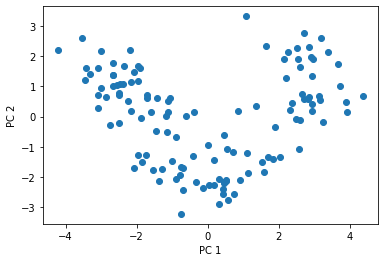

In [79]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

#### 이제 sklearn의 PCA로 훈련 데이터를 변환하고, 로지스틱 회귀 모델로 분류하고 결정경계를 만들어보자.

In [84]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(random_state=1)
lr = lr.fit(X_train_pca, y_train)

/Users/jihun/Documents/data_science/notebooks/mlbook_Raschka/plots_.py:44: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


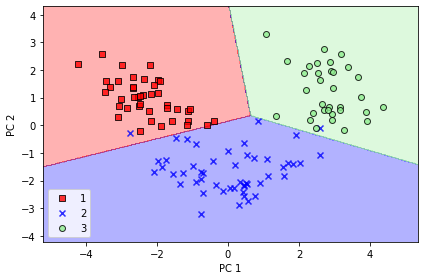

In [87]:
from plots_ import plot_decision_regions

plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_04.png', dpi=300)
plt.show()

/Users/jihun/Documents/data_science/notebooks/mlbook_Raschka/plots_.py:44: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


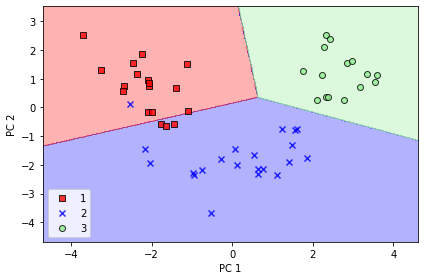

In [88]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()

plt.show()

In [89]:
# 전체 주성분의 explained variance ratio를 알고 싶다면 n_components를 None으로 하면 된다.
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

`n_components`에 (0, 1) 사이 실수를 입력하면 설명된 분산의 비율을 나타냅니다. 이 비율을 달성하기 위해 필요한 주성분 개수를 선택합니다.

In [90]:
pca = PCA(n_components=0.95)
pca.fit(X_train_std)
print('주성분 개수:', pca.n_components_)
print('설명된 분산 비율:', np.sum(pca.explained_variance_ratio_))

주성분 개수: 10
설명된 분산 비율: 0.9662714406558744


## 5.2 선형 판별 분석을 통한 지도 방식의 데이터 압축
- Linear Discriminant Analysis(LDA)는 규제가 없는 모델에서 차원의 저주로 인한 과대적합 정도를 줄이고 계산 효율성을 높이기 위한 특성 추출의 기법으로 사용할 수 있다.<br>

> "PCA가 데이터셋에 있는 분산이 최대인 직교 성분 축을 찾으려고 하는 반면, LDA 목표는 클래스를 최적으로 구분할 수 있는 특성 부분 공간을 찾는 것이다."

### 5.2.1 주성분 분석 vs 선형 판별 분석

In [91]:
Image(url='https://git.io/Jtsv8', width=350) 

**동작 방식**<br>
1. $d$차원의 데이터셋을 표준화 전처리한다. ($d$는 특성 개수)
2. 각 클래스에 대해 $d$차원의 평균 벡터를 계산한다.
3. 클래스 간의 산포 행렬(scatter matrix) $\boldsymbol S_B$와 클래스 내 산포 행렬 $\boldsymbol S_w$를 구성한다.
4. $\boldsymbol S_W^{-1} \boldsymbol S_B$ 행렬의 고유 벡터와 고윳값을 계산한다.
5. 고윳값을 내림차순으로 정렬하여 고유 벡터의 순서를 매긴다.
6. 고윳값이 가장 큰 $k$개의 고유 벡터를 선택하여 $d \times k$ 차원의 변환 행렬 $\boldsymbol W$를 구성한다. 이 행렬의 열이 고유 벡터다.
7. 변환 행렬 $\boldsymbol W$를 사용하여 샘플을 새로운 특성 부분 공간으로 투영한다.

### 5.2.3 산포 행렬 계산

- 위에서 표준화한 wine 데이터셋 사용해서 평균 벡터 구하기
    - 평균 벡터를 사용하여 클래스 간의 산포 행렬과 클래스 내 산포 행렬을 구성한다.
    - 평균 벡터 $\boldsymbol m_i$는 클래스 $i$의 샘플에 대한 특성의 평균값 $\mu_m$을 저장한다.

> 평균 벡터는.. <br>

$$ \boldsymbol m_i = \dfrac{1}{n_i} \sum_{\boldsymbol x \in D_i} \boldsymbol x_m $$ <br>

$$ \boldsymbol m_i = \begin{pmatrix} \mu_{i,alcohol} \\ \mu_{i,malicacid} \\ \dots \\ \mu_{i_proline} \end{pmatrix},\;\; i \in \{1,2,3\} $$

In [92]:
# 각 클래스에 대한 평균 벡터를 계산한다

np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



#### 클래스 내 산포 행렬을 계산합니다:

$\boldsymbol S_W=\sum_{i=1}^c \boldsymbol S_i$

$\boldsymbol S_i=\sum_{x\in D_i}(\boldsymbol x-\boldsymbol m_i)^T(\boldsymbol x-\boldsymbol m_i)$

In [97]:
d = 13 # 특성의 수
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d)) # 각 클래스에 대한 산포 행렬
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1) # 열 벡터로 만들기
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter  # 클래스 산포 행렬을 더한다.
    
print('클래스 내의 산포 행렬: %sx%s' % (S_W.shape[0], S_W.shape[1]))
print('클래스 레이블 분포: %s' % np.bincount(y_train)[1:])

클래스 내의 산포 행렬: 13x13
클래스 레이블 분포: [41 50 33]


- 근데 위에서 보듯이, 이 데이터셋이 클래스가 균일하게 분포되지 않은 데이터다.
    - **산포 행렬의 계산은 훈련 데이터셋의 클래스 레이블이 균등하게 분포되어 있다고 가정**한다.
    - 만약 균등하지 않다면 공분산 행렬을 사용하는 것이 낫다.

$\sum_i=\dfrac{1}{n_i}\boldsymbol S_i=\dfrac{1}{n_i}\sum_{x\in D_i}(\boldsymbol x-\boldsymbol m_i)^T(\boldsymbol x-\boldsymbol m_i)$ <br><br>

- 산포 행렬을 샘플 개수 $n_i$로 나누면 사실 산포 행렬을 계산하는 것이 공분산 행렬 $\sum_i$ 를 계산하는 것과 같아진다. **즉, 공분산 행렬은 산포 행렬의 정규화 버전이다.**

In [102]:
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('스케일 조정된 클래스 내의 산포 행렬: %sx%s' % (S_W.shape[0], S_W.shape[1]))

스케일 조정된 클래스 내의 산포 행렬: 13x13


#### 클래스 내 산포 행렬(또는 공분산 행렬)을 계산한 후 다음 단계는 클래스 간 산포 행렬을 계산하는 것이다

$\boldsymbol S_B=\sum_{i=1}^c n_i(\boldsymbol m_i-\boldsymbol m)^T(\boldsymbol m_i-\boldsymbol m)$<br>

- 여기서 $\boldsymbol m$은 모든 클래스의 샘플을 포함하여 계산된 전체 평균이다.

In [116]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
    
print('클래스 간의 산포 행렬: %sx%s' % (S_B.shape[0], S_B.shape[1]))

클래스 간의 산포 행렬: 13x13


### 5.2.4 새로운 특성 부분 공간을 위해 선형 판별 벡터 선택
- 이제 다음 단계는..
    - PCA라면 공분산 행렬에 대한 고윳값 분해를 하는 건데,
    - LDA는 대신 행렬 $\boldsymbol S_W^{-1} \boldsymbol W_B$의 고윳값을 계산한다.

In [129]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

- 고윳값의 역순으로 고유벡터를 정렬한다 (판별 벡터의 개수 = 클래스 개수 -1):

In [130]:
# (고윳값, 고유벡터) 튜플의 리스트를 만든다
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
              for i in range(len(eigen_vals))]

# (고윳값, 고유벡터) 튜플을 큰 값에서 작은 값 순서로 정렬한다
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# 고윳값의 역순으로 올바르게 정렬되었는지 확인한다
print('내림차순의 고윳값:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

내림차순의 고윳값:

349.6178089059941
172.76152218979385
2.842170943040401e-14
2.564925776858485e-14
2.4338020883285312e-14
2.4338020883285312e-14
2.0175057173967873e-14
1.4666248938581886e-14
1.4666248938581886e-14
6.749911050291042e-15
6.749911050291042e-15
4.473806353827043e-15
1.1725209460862484e-15


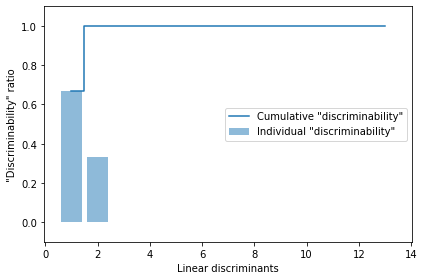

In [136]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
       label='Individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
       label='Cumulative "discriminability"')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()

plt.show()

In [137]:
# 변환 행렬 W:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('행렬 W:\n', w)

행렬 W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


### 5.2.5 새로운 특성 공간으로 샘플 투영
- 변환 행렬을 훈련 데이터셋에 곱해서 데이터를 변환할 수 있다.<br><br>
$$\boldsymbol X'=\boldsymbol X \boldsymbol W$$

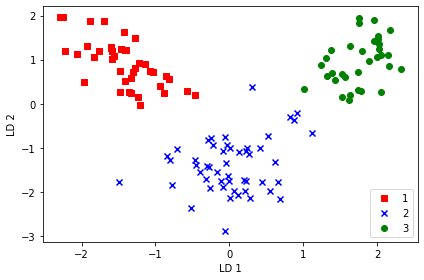

In [142]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
               X_train_lda[y_train == l, 1] * (-1),
               c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()

plt.show()

### 5.2.6 사이킷런의 LDA

In [143]:
# LDA로 차원 축소한 데이터에서 LogisticRegression 모델 성능 확인하기
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

/Users/jihun/Documents/data_science/notebooks/mlbook_Raschka/plots_.py:44: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


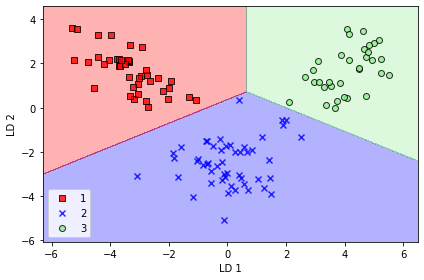

In [144]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=1)
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()

plt.show()

/Users/jihun/Documents/data_science/notebooks/mlbook_Raschka/plots_.py:44: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


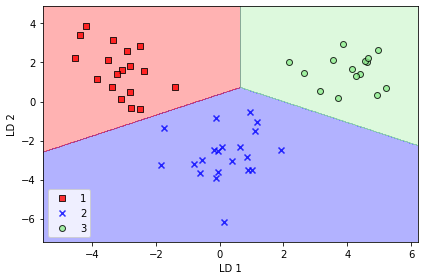

In [146]:
# 테스트 세트에 대한 성능 확인
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()

plt.show()

## 5.3 커널 PCA를 사용하여 비선형 매핑

- 커널 PCA를 사용하여 선형적으로 구분되지 않는 데이터를 선형 분류기에 적합한 새로운 저차원 부분 공간으로 변환할 수 있다.

### 5.3.1 커널 함수와 커널 트릭

#### 3.5.2의 커널 SVM에서 나왔던 거 다시 보면..
- 커널 방법의 기본 아이디어는
    - $(x_1, x_2)$라는 특성에다가 커널 함수를 적용시켜서,
    - $\phi(x_1, x_2)\;=\;(z_1,z_2,z_3)\;=\;(x_1,x_2,\;x_1^2 + x_2^2)$라는 고차원으로 매핑시키는 것이다.<br><br>

- 근데 위 방법의 문제는 $x_1^2 + x_2^2$, 즉... $\boldsymbol x^{(i)T} \cdot \boldsymbol x^{(j)}$ 라는 dot product의 계산 비용이 아주 비싸다는 것이다.
    - 그래서 사용하는 게 '커널 트릭'이다. => 계산 비용 절감을 위한 커널 함수를 정의하는 것이다.
    - 위의 dot product의 계산을 커널 함수를 푸는 것으로 바꾸는 거다.
    - $$ \kappa (\boldsymbol x^{(i)},\boldsymbol x^{(j)}) = \phi(\boldsymbol x^{(i)})^T \phi(\boldsymbol x^{(j)})$$

- 가장 많이 사용되는 커널 중 하나는 방사 기저 함수(Radial Basis Function, RBF)다. 가우시안 커널(Gaussian Kernel)이라고도 불린다.<br>

$$ \kappa (\boldsymbol x^{(i)}, \boldsymbol x^{(j)})\;=\;exp \bigg(- \dfrac{||\boldsymbol x^{(i)} - \boldsymbol x^{(j)}||^2}{2\sigma^2} \bigg) $$<br><br>

- 간단하게 아래와 같이 쓰기도 한다.
$$ \kappa (\boldsymbol x^{(i)}, \boldsymbol x^{(j)})\;=\;exp \big(- \gamma ||\boldsymbol x^{(i)} - \boldsymbol x^{(j)}||^2 \big) $$

> 대략적으로 말하면 '커널'을 샘플 간의 '유사도 함수(similarity function)'로 해석할 수 있다.

#### 커널 PCA 설명

- 커널 PCA도 커널 SVM과 비슷하다.
- 커널 PCA는 비선형 매핑을 수행하여 데이터를 고차원 공간으로 변환하고, 그 다음 고차원 공간에서 표준 PCA를 사용하여 샘플이 선형 분류기로 구분될 수 있는 저차원 공간으로 데이터를 투영한다. (샘플이 이 입력 공간에서 잘 구분될 수 있다고 가정한다)
    - 이 방식이 계산 비용이 비싸기 때문에, 커널 PCA도 커널 SVM처럼 커널 트릭을 사용한다.
    - 커널 트릭을 사용하면 "원본 특성 공간에서 두 고차원 특성 벡터의 유사도를 계산할 수 있게 된다."

**먼저 표준 PCA를 다시 생각해보자**

1. 두 개의 특성 $k$와 $j$ 사이의 공분산은 다음과 같이 계산한다.
    - $\sigma_{jk} = \dfrac{1}{n} \sum^n_{i=1} (x^{(i)}_j - \mu_j)(x^{(i)}_k - \mu_k)$<br>

2. 특성 평균을 0에 맞추었으므로 위 식을 다음과 같이 간단히 쓸 수 있다.
    - $\sigma_{jk} = \dfrac{1}{n} \sum^n_{i=1} x^{(i)}_j x^{(i)}_k$<br>
    
3. 이 식은 두 특성 간의 공분산을 의미한다. 공분산 행렬 $\sum$를 계산하는 일반식으로 써보자.
    - $\sum = \dfrac{1}{n} \sum^n_{i=1} x^{(i)} x^{(i)^T}$<br>
    
4. 베른하르트 슐코프가 이 방식을 일반화하여 $\phi$를 통한 비선형 특성 조합으로 원본 특성 공간의 샘플 사이의 점곱을 대체했다.
    - $\sum = \dfrac{1}{n} \sum^n_{i=1} \phi(x^{(i)}) \phi(x^{(i)})^T$<br>
    
5. 이 공분산 행렬에서 고유 벡터(주성분)를 얻기 위해서는 다음 식을 풀어야 한다.
    - $\sum \boldsymbol \nu = \lambda \boldsymbol \nu$
    - $\Rightarrow \dfrac{1}{n} \sum^n_{i=1} \phi(x^{(i)}) \phi(x^{(i)})^T \boldsymbol \nu = \lambda \boldsymbol \nu$
    - $\Rightarrow \boldsymbol \nu = \dfrac{1}{n\lambda} \sum^n_{i=1} \phi(x^{(i)}) \phi(x^{(i)})^T \boldsymbol \nu = \sum^n_{i=1} \boldsymbol a^{(i)} \phi(\boldsymbol x^{(i)})$<br><br>
    
6. 위에서 $\lambda$와 $\boldsymbol \nu$는 공분산 행렬 $\sum$의 고윳값과 고유 벡터다. $\boldsymbol a$는 커널(유사도) 행렬 $\boldsymbol K$의 고유 벡터를 추출함으로써 구할 수 있다.

7. 커널 행렬의 유도
    - 먼저 공분산 행렬을 행렬 표기법으로 나타내자. X는 $n \times k$차원 행렬이다.
    - $\sum = \dfrac{1}{n} \sum^n_{i=1} \phi(x^{(i)}) \phi(x^{(i)})^T = \dfrac{1}{n} \phi(\boldsymbol X)^T \phi(\boldsymbol X)$<br><br>
    
    - 고유 벡터 식은 다음과 같이 쓸 수 있다.
    - $\boldsymbol \nu = \sum^n_{i=1} \boldsymbol a^{(i)} \phi(\boldsymbol x^{(i)}) = \phi(\boldsymbol X)^T \boldsymbol a$<br><br>
    
    - $\sum \boldsymbol \nu = \lambda \boldsymbol \nu$ 이기 때문에 다음을 얻는다.
        - $\dfrac{1}{n} \phi(\boldsymbol X)^T \phi(\boldsymbol X)\phi(\boldsymbol X)^T \boldsymbol a = \lambda \phi(\boldsymbol X)\phi(\boldsymbol X)^T \boldsymbol a$
        - $\Rightarrow \dfrac{1}{n} \phi(\boldsymbol X)\phi(\boldsymbol X)^T \boldsymbol a = \lambda \boldsymbol a$
        - $\Rightarrow \dfrac{1}{n} \boldsymbol K \boldsymbol a = \lambda \boldsymbol a$<br><br>
        
- 여기서 K는 유사도(커널) 행렬이다.<br>
$$ \boldsymbol K = \phi(\boldsymbol X)\phi(\boldsymbol X)^T $$

#### RBF 커널 PCA를 구현하기 위해 다음 3단계를 정의한다.
1. 커널 (유사도) 행렬 $\boldsymbol K$를 다음 식으로 계산한다.
    - $\kappa (\boldsymbol x^{(i)}, \boldsymbol x^{(j)})\;=\;exp \big(- \gamma ||\boldsymbol x^{(i)} - \boldsymbol x^{(j)}||^2 \big)$
    - 여기서 $\gamma = \dfrac{1}{2\sigma^2}$
    - 샘플의 모든 쌍에 대해 구한다.
        - 예를 들어 100개의 훈련 샘플이 담긴 데이터넷이면, 각 쌍의 유사도를 담은 대칭 커널 행렬은 100x100 차원이 된다.<br><br>
        
2. 다음 식을 사용하여 커널 행렬 $\boldsymbol K$를 중앙에 맞춘다.
    - $\boldsymbol K^{'} = \boldsymbol K - 1_n \boldsymbol K - \boldsymbol K 1_n + 1_n \boldsymbol K 1_n $
    - $1_n$은 모든 값이 $\dfrac{1}{n}$인 $n \times n$차원 행렬이다. (커널 행렬과 같은 차원)<br><br>

3. 고윳값 크기대로 내림차순으로 정렬하여 중앙에 맞춘 커널 행렬에서 최상위 $k$개의 고유 벡터를 고른다. 표준 PCA와 다르게 고유 벡터는 주성분 축이 아니며, 이미 이 축에 투영된 샘플이다.

### 5.3.2 파이썬으로 커널 PCA 구현

In [150]:
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import numpy as np

from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version

if scipy_version >= Version('1.4.1'):
    from numpy import exp
else:
    from scipy import exp


def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF 커널 PCA 구현
    
    매개변수
    -----------
    X: {넘파이 ndarray}, shape = [n_samples, n_features]
    
    gamma: float
      RBF 커널 튜닝 매개변수
    
    n_components: int
      반환할 주성분 개수
    
    반환값
    -----------
      X_pc: {넘파이 ndarray}, shape = [n_samples, k_features]
        투영된 데이터셋
    """
    # MxN 차원의 데이터셋에서 샘플 간의 유클리디안 거리의 제곱을 계산한다.
    sq_dists = pdist(X, 'sqeuclidean')
    
    # 샘플 간의 거리를 정방 대칭 행렬로 변환한다.
    mat_sq_dists = squareform(sq_dists)
    
    # 커널 행렬을 계산한다.
    K = exp(-gamma * mat_sq_dists)
    
    # 커널 행렬을 중앙에 맞춥니다.
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # 중앙에 맞춰진 커널 행렬의 고윳값과 고유벡터를 구한다.
        # scipy.linalg.eigh 함수는 오름차순으로 반환한다.
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    
    # 최상위 k 개의 고유벡터를 선택한다. (결과값은 투영된 샘플이다)
    X_pc = np.column_stack([eigvecs[:, i]
                           for i in range(n_components)])
    
    return X_pc

#### 예제 1: 반달 모양 구분하기

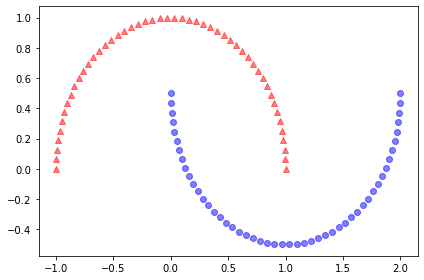

In [151]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()

plt.show()

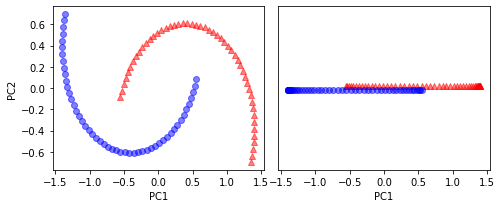

In [152]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()

plt.show()

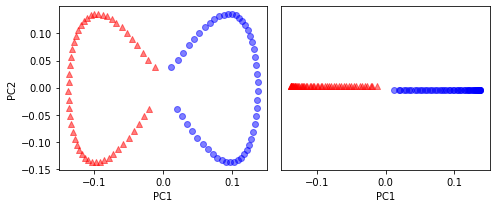

In [153]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50, 1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50, 1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()

plt.show()